In [1]:
import csv
import cv2
import itertools
import numpy as np
import pandas as pd
import os
import sys
import tempfile
import tqdm

from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

import tensorflow as tf
# import tensorflow_hub as hub
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [1]:
pose_sample_rpi_path = os.path.join(os.getcwd(), './movenet')
sys.path.append(pose_sample_rpi_path)

# Load MoveNet Thunder model
import utils
from data import BodyPart
from ml import Movenet
movenet = Movenet('movenet_thunder')


def detect(input_tensor, inference_count=3):
  
  image_height, image_width, channel = input_tensor.shape
 
  movenet.detect(input_tensor.numpy(), reset_crop_region=True)

  for _ in range(inference_count - 1):
    person = movenet.detect(input_tensor.numpy(), 
                            reset_crop_region=False)

  return person

In [3]:
def draw_prediction_on_image(
    image, person, crop_region=None, close_figure=True,
    keep_input_size=False):
  

  image_np = utils.visualize(image, [person])
  
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  im = ax.imshow(image_np)
 
  if close_figure:
    plt.close(fig)
 
  if not keep_input_size:
    image_np = utils.keep_aspect_ratio_resizer(image_np, (512, 512))

  return image_np

In [4]:
class MoveNetPreprocessor(object):
 
  def __init__(self,
               images_in_folder,
               images_out_folder,
               csvs_out_path):
   
    self._images_in_folder = images_in_folder
    self._images_out_folder = images_out_folder
    self._csvs_out_path = csvs_out_path
    self._messages = []

    self._csvs_out_folder_per_class = tempfile.mkdtemp()
 
    self._pose_class_names = sorted(
        [n for n in os.listdir(self._images_in_folder) if not n.startswith('.')]
        )
    
  def process(self, per_pose_class_limit=None, detection_threshold=0.1):

    for pose_class_name in self._pose_class_names:
      print('Preprocessing', pose_class_name, file=sys.stderr)


      images_in_folder = os.path.join(self._images_in_folder, pose_class_name)
      images_out_folder = os.path.join(self._images_out_folder, pose_class_name)
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  pose_class_name + '.csv')
      if not os.path.exists(images_out_folder):
        os.makedirs(images_out_folder)
 
      with open(csv_out_path, 'w') as csv_out_file:
        csv_out_writer = csv.writer(csv_out_file, 
                                    delimiter=',', 
                                    quoting=csv.QUOTE_MINIMAL)
        # Get list of images
        image_names = sorted(
            [n for n in os.listdir(images_in_folder) if not n.startswith('.')])
        if per_pose_class_limit is not None:
          image_names = image_names[:per_pose_class_limit]

        valid_image_count = 0
 
        for image_name in tqdm.tqdm(image_names):
          image_path = os.path.join(images_in_folder, image_name)

          try:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
          except:
            self._messages.append('Skipped ' + image_path + '. Invalid image.')
            continue
          else:
            image = tf.io.read_file(image_path)
            image = tf.io.decode_jpeg(image)
            image_height, image_width, channel = image.shape
          

          if channel != 3:
            self._messages.append('Skipped ' + image_path +
                                  '. Image isn\'t in RGB format.')
            continue
          person = detect(image)
          

          min_landmark_score = min(
              [keypoint.score for keypoint in person.keypoints])
          should_keep_image = min_landmark_score >= detection_threshold
          if not should_keep_image:
            self._messages.append('Skipped ' + image_path +
                                  '. No pose was confidentlly detected.')
            continue

          valid_image_count += 1

       
          output_overlay = draw_prediction_on_image(
              image.numpy().astype(np.uint8), person, 
              close_figure=True, keep_input_size=True)
        
        
          output_frame = cv2.cvtColor(output_overlay, cv2.COLOR_RGB2BGR)
          cv2.imwrite(os.path.join(images_out_folder, image_name), output_frame)
        

          pose_landmarks = np.array(
              [[keypoint.coordinate.x, keypoint.coordinate.y, keypoint.score]
                for keypoint in person.keypoints],
              dtype=np.float32)

        
          coordinates = pose_landmarks.flatten().astype(np.str).tolist()
          csv_out_writer.writerow([image_name] + coordinates)

        if not valid_image_count:
          raise RuntimeError(
              'No valid images found for the "{}" class.'
              .format(pose_class_name))
      

    print('\n'.join(self._messages))


    all_landmarks_df = self._all_landmarks_as_dataframe()
    all_landmarks_df.to_csv(self._csvs_out_path, index=False)

  def class_names(self):
    """List of classes found in the training dataset."""
    return self._pose_class_names
  
  def _all_landmarks_as_dataframe(self):
    """Merge all per-class CSVs into a single dataframe."""
    total_df = None
    for class_index, class_name in enumerate(self._pose_class_names):
      csv_out_path = os.path.join(self._csvs_out_folder_per_class,
                                  class_name + '.csv')
      per_class_df = pd.read_csv(csv_out_path, header=None)
      
     
      per_class_df['class_no'] = [class_index]*len(per_class_df)
      per_class_df['class_name'] = [class_name]*len(per_class_df)

    
      per_class_df[per_class_df.columns[0]] = (os.path.join(class_name, '') 
        + per_class_df[per_class_df.columns[0]].astype(str))

      if total_df is None:
        total_df = per_class_df
      else:
        total_df = pd.concat([total_df, per_class_df], axis=0)
 
    list_name = [[bodypart.name + '_x', bodypart.name + '_y', 
                  bodypart.name + '_score'] for bodypart in BodyPart] 
    header_name = []
    for columns_name in list_name:
      header_name += columns_name
    header_name = ['file_name'] + header_name
    header_map = {total_df.columns[i]: header_name[i] 
                  for i in range(len(header_name))}
 
    total_df.rename(header_map, axis=1, inplace=True)

    return total_df

In [32]:
image = tf.io.read_file('./pose.jpg')
image = tf.io.decode_jpeg(image)
person = detect(image)
_ = draw_prediction_on_image(image.numpy(), person, crop_region=None, 
                            close_figure=False, keep_input_size=True)

ValueError: Cannot set tensor: Dimension mismatch. Got 3 but expected 4 for input 0.

In [7]:
import os
import random
import shutil

def split_into_train_test(images_origin, images_dest, test_split):

  _, dirs, _ = next(os.walk(images_origin))

  TRAIN_DIR = os.path.join(images_dest, 'train')
  TEST_DIR = os.path.join(images_dest, 'test')
  os.makedirs(TRAIN_DIR, exist_ok=True)
  os.makedirs(TEST_DIR, exist_ok=True)

  for dir in dirs:
    # Get all filenames for this dir, filtered by filetype
    filenames = os.listdir(os.path.join(images_origin, dir))
    filenames = [os.path.join(images_origin, dir, f) for f in filenames if (
        f.endswith('.png') or f.endswith('.jpg') or f.endswith('.jpeg') or f.endswith('.bmp'))]
    # Shuffle the files, deterministically
    filenames.sort()
    random.seed(42)
    random.shuffle(filenames)
    # Divide them into train/test dirs
    os.makedirs(os.path.join(TEST_DIR, dir), exist_ok=True)
    os.makedirs(os.path.join(TRAIN_DIR, dir), exist_ok=True)
    test_count = int(len(filenames) * test_split)
    for i, file in enumerate(filenames):
      if i < test_count:
        destination = os.path.join(TEST_DIR, dir, os.path.split(file)[1])
      else:
        destination = os.path.join(TRAIN_DIR, dir, os.path.split(file)[1])
      shutil.copyfile(file, destination)
    print(f'Moved {test_count} of {len(filenames)} from class "{dir}" into test.')
  print(f'Your split dataset is in "{images_dest}"')

In [42]:
if use_custom_dataset:
  dataset_in = 'poses'
  if not os.path.isdir(dataset_in):
    raise Exception("dataset_in is not a valid directory")
  if dataset_is_split:
    IMAGES_ROOT = dataset_in
  else:
    dataset_out = 'split_' + dataset_in
    split_into_train_test(dataset_in, dataset_out, test_split=0.2)
    IMAGES_ROOT = dataset_out

Moved 225 of 1126 from class "lie" into test.
Moved 423 of 2115 from class "lie_faceDown" into test.
Moved 121 of 606 from class "lie_side" into test.
Moved 524 of 2620 from class "sit_cross_legged" into test.
Moved 334 of 1674 from class "sit_on_chair" into test.
Your split dataset is in "split_./poses"


In [43]:
images_in_train_folder = os.path.join(IMAGES_ROOT, 'train')
images_out_train_folder = 'poses_images_out_train'
csvs_out_train_path = 'train_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_train_folder,
    images_out_folder=images_out_train_folder,
    csvs_out_path=csvs_out_train_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing lie
  0%|          | 0/901 [00:00<?, ?it/s]C:\Users\TaeHo\AppData\Local\Temp/ipykernel_15200/1291585794.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
  8%|▊         | 71/901 [00:11<01:22, 10.05it/s]D:\Program Files\Python\Python39\lib\site-packages\numpy\lib\function_base.py:495: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
D:\Program Files\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 901/901 [02:03<00:00,  7.29it/s]
Preprocessing lie_faceDown
10

Skipped split_./poses\train\lie\16_F150B_3_312.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_313.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_314.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_315.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_316.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_317.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_319.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_322.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_323.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_327.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_329.jpg. No pose was confidentlly detected.
Skipped split_./poses\train\lie\16_F150B_3_

In [44]:
images_in_test_folder = os.path.join(IMAGES_ROOT, 'test')
images_out_test_folder = 'poses_images_out_test'
csvs_out_test_path = 'test_data.csv'

preprocessor = MoveNetPreprocessor(
    images_in_folder=images_in_test_folder,
    images_out_folder=images_out_test_folder,
    csvs_out_path=csvs_out_test_path,
)

preprocessor.process(per_pose_class_limit=None)

Preprocessing lie
  0%|          | 0/225 [00:00<?, ?it/s]C:\Users\TaeHo\AppData\Local\Temp/ipykernel_15200/1291585794.py:128: DeprecationWarning: `np.str` is a deprecated alias for the builtin `str`. To silence this warning, use `str` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.str_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  coordinates = pose_landmarks.flatten().astype(np.str).tolist()
100%|██████████| 225/225 [00:32<00:00,  6.96it/s]
Preprocessing lie_faceDown
100%|██████████| 423/423 [00:48<00:00,  8.75it/s]
Preprocessing lie_side
100%|██████████| 121/121 [00:14<00:00,  8.55it/s]
Preprocessing sit_cross_legged
100%|██████████| 524/524 [01:10<00:00,  7.47it/s]
Preprocessing sit_on_chair
100%|██████████| 334/334 [00:59<00:00,  5.66it/s]


Skipped split_./poses\test\lie\16_F150B_3_321.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_3_336.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_3_357.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_3_362.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_3_365.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_302.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_327.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_329.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_333.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_334.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_337.jpg. No pose was confidentlly detected.
Skipped split_./poses\test\lie\16_F150B_4_345.jpg. No 

In [46]:
def load_pose_landmarks(csv_path):

  # Load the CSV file
  dataframe = pd.read_csv(csv_path)
  df_to_process = dataframe.copy()

  # Drop the file_name columns as you don't need it during training.
  df_to_process.drop(columns=['file_name'], inplace=True)

  # Extract the list of class names
  classes = df_to_process.pop('class_name').unique()

  # Extract the labels
  y = df_to_process.pop('class_no')

  # Convert the input features and labels into the correct format for training.
  X = df_to_process.astype('float64')
  y = keras.utils.to_categorical(y)

  return X, y, classes, dataframe

In [47]:
# Load the train data
X, y, class_names, _ = load_pose_landmarks(csvs_out_train_path)

# Split training data (X, y) into (X_train, y_train) and (X_val, y_val)
X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.15)

In [48]:
# Load the test data
X_test, y_test, _, df_test = load_pose_landmarks(csvs_out_test_path)

In [49]:
def get_center_point(landmarks, left_bodypart, right_bodypart):

  left = tf.gather(landmarks, left_bodypart.value, axis=1)
  right = tf.gather(landmarks, right_bodypart.value, axis=1)
  center = left * 0.5 + right * 0.5
  return center


def get_pose_size(landmarks, torso_size_multiplier=2.5):
  # Hips center
  hips_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)

  # Shoulders center
  shoulders_center = get_center_point(landmarks, BodyPart.LEFT_SHOULDER,
                                      BodyPart.RIGHT_SHOULDER)

  # Torso size as the minimum body size
  torso_size = tf.linalg.norm(shoulders_center - hips_center)

  # Pose center
  pose_center_new = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                     BodyPart.RIGHT_HIP)
  pose_center_new = tf.expand_dims(pose_center_new, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to
  # perform substraction
  pose_center_new = tf.broadcast_to(pose_center_new,
                                    [tf.size(landmarks) // (17*2), 17, 2])

  # Dist to pose center
  d = tf.gather(landmarks - pose_center_new, 0, axis=0,
                name="dist_to_pose_center")
  # Max dist to pose center
  max_dist = tf.reduce_max(tf.linalg.norm(d, axis=0))

  # Normalize scale
  pose_size = tf.maximum(torso_size * torso_size_multiplier, max_dist)

  return pose_size


def normalize_pose_landmarks(landmarks):
  # Move landmarks so that the pose center becomes (0,0)
  pose_center = get_center_point(landmarks, BodyPart.LEFT_HIP, 
                                 BodyPart.RIGHT_HIP)
  pose_center = tf.expand_dims(pose_center, axis=1)
  # Broadcast the pose center to the same size as the landmark vector to perform
  # substraction
  pose_center = tf.broadcast_to(pose_center, 
                                [tf.size(landmarks) // (17*2), 17, 2])
  landmarks = landmarks - pose_center

  # Scale the landmarks to a constant pose size
  pose_size = get_pose_size(landmarks)
  landmarks /= pose_size

  return landmarks


def landmarks_to_embedding(landmarks_and_scores):
  """Converts the input landmarks into a pose embedding."""
  # Reshape the flat input into a matrix with shape=(17, 3)
  reshaped_inputs = keras.layers.Reshape((17, 3))(landmarks_and_scores)

  # Normalize landmarks 2D
  landmarks = normalize_pose_landmarks(reshaped_inputs[:, :, :2])

  # Flatten the normalized landmark coordinates into a vector
  embedding = keras.layers.Flatten()(landmarks)

  return embedding

In [50]:
# Define the model
inputs = tf.keras.Input(shape=(51))
embedding = landmarks_to_embedding(inputs)

layer = keras.layers.Dense(128, activation=tf.nn.relu6)(embedding)
layer = keras.layers.Dropout(0.5)(layer)
layer = keras.layers.Dense(64, activation=tf.nn.relu6)(layer)
layer = keras.layers.Dropout(0.5)(layer)
outputs = keras.layers.Dense(len(class_names), activation="softmax")(layer)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 51)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 17, 3)        0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 17, 2)       0           ['reshape[0][0]']                
 ingOpLambda)                                                                                     
                                                                                                  
 tf.compat.v1.gather (TFOpLambd  (None, 2)           0           ['tf.__operators__.getitem[0]

In [51]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Add a checkpoint callback to store the checkpoint that has the highest
# validation accuracy.
checkpoint_path = "weights.best.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                              patience=20)

# Start training
history = model.fit(X_train, y_train,
                    epochs=200,
                    batch_size=16,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
240/242 [============================>.] - ETA: 0s - loss: 1.0912 - accuracy: 0.5883
Epoch 1: val_accuracy improved from -inf to 0.78886, saving model to weights.best.hdf5
242/242 [==============================] - 1s 2ms/step - loss: 1.0915 - accuracy: 0.5875 - val_loss: 0.5991 - val_accuracy: 0.7889
Epoch 2/200
226/242 [===========================>..] - ETA: 0s - loss: 0.5503 - accuracy: 0.8147
Epoch 2: val_accuracy improved from 0.78886 to 0.90616, saving model to weights.best.hdf5
242/242 [==============================] - 0s 2ms/step - loss: 0.5431 - accuracy: 0.8160 - val_loss: 0.3285 - val_accuracy: 0.9062
Epoch 3/200
200/242 [=======================>......] - ETA: 0s - loss: 0.3773 - accuracy: 0.8759
Epoch 3: val_accuracy improved from 0.90616 to 0.95161, saving model to weights.best.hdf5
242/242 [==============================] - 0s 1ms/step - loss: 0.3655 - accuracy: 0.8822 - val_loss: 0.2231 - val_accuracy: 0.9516
Epoch 4/200
203/242 [========================>...

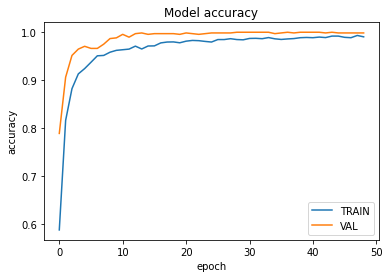

In [52]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [53]:
# Evaluate the model using the TEST dataset
loss, accuracy = model.evaluate(X_test, y_test)

35/35 [==============================] - 0s 659us/step - loss: 0.0561 - accuracy: 0.9901


In [55]:
print(X_test)
predictions = model.predict(X_test)
print("\n테스트 데이터의 Accuracy 값: ", accuracy)
for i in range(1108):
    print("%d 번째 테스트 데이터의 예측값: %d" % (i+1, np.argmax(predictions[i])))

      NOSE_x  NOSE_y  NOSE_score  LEFT_EYE_x  LEFT_EYE_y  LEFT_EYE_score  \
0     1015.0   590.0    0.620147      1015.0       587.0        0.474253   
1     1014.0   592.0    0.748114      1012.0       586.0        0.741333   
2     1013.0   590.0    0.836696      1011.0       587.0        0.827519   
3     1014.0   591.0    0.685936      1012.0       587.0        0.773293   
4     1012.0   590.0    0.804282      1011.0       586.0        0.564012   
...      ...     ...         ...         ...         ...             ...   
1102   965.0   421.0    0.603499       976.0       414.0        0.638528   
1103   964.0   420.0    0.756045       976.0       413.0        0.803938   
1104   964.0   420.0    0.701396       976.0       413.0        0.488412   
1105   965.0   421.0    0.649147       976.0       414.0        0.353780   
1106   966.0   421.0    0.589664       978.0       413.0        0.650765   

      RIGHT_EYE_x  RIGHT_EYE_y  RIGHT_EYE_score  LEFT_EAR_x  ...  \
0          1000.0  

IndexError: index 1107 is out of bounds for axis 0 with size 1107

Confusion matrix, without normalization

Classification Report:
                   precision    recall  f1-score   support

             lie       0.98      0.99      0.99       180
    lie_faceDown       0.98      0.99      0.98       211
        lie_side       0.99      0.95      0.97        73
sit_cross_legged       1.00      1.00      1.00       425
    sit_on_chair       1.00      1.00      1.00       218

        accuracy                           0.99      1107
       macro avg       0.99      0.98      0.99      1107
    weighted avg       0.99      0.99      0.99      1107



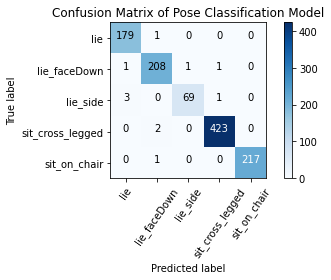

In [56]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """Plots the confusion matrix."""
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization')

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=55)
  plt.yticks(tick_marks, classes)
  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

# Classify pose in the TEST dataset using the trained model
y_pred = model.predict(X_test)

# Convert the prediction result to class name
y_pred_label = [class_names[i] for i in np.argmax(y_pred, axis=1)]
y_true_label = [class_names[i] for i in np.argmax(y_test, axis=1)]

# Plot the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
plot_confusion_matrix(cm,
                      class_names,
                      title ='Confusion Matrix of Pose Classification Model')

# Print the classification report
print('\nClassification Report:\n', classification_report(y_true_label,
                                                          y_pred_label))